In [1]:
# !pip install bertopic
# !pip install bertopic[visualization]
from bertopic import BERTopic

/Users/yco/opt/anaconda3/envs/IS4242/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-12 08:31:09.606896: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import Model
import joblib
model = joblib.load("model_bert_new.pkl")

In [3]:
# Visualize Model
model.visualize_barchart()

In [4]:
# !pip install requests_html
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession
from bs4 import BeautifulSoup

import nltk
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')
# nltk.download('brown')
# nltk.download('punkt')
# nltk.download('omw-1.4')

from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from string import punctuation
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_source(url):
    try:
        session = HTMLSession()
        response = session.get(url)
        return response
    except requests.exceptions.RequestException as e:
        print(e)

def scrape(q):
    q = urllib.parse.quote_plus(q)
    result = get_source("https://www.google.com/search?q=" + q)
    lst = list(result.html.absolute_links)
    exclude_domains = ('google', 'https://google.', 'https://webcache.googleusercontent.', 'http://webcache.googleusercontent.', 'https://policies.google.',
                       'https://support.google.','https://maps.google.','https://www.instagram.','https://www.youtube.', 'facebook', 'tripadvisor')
    links = lst.copy()
    for url in lst:
        for domain in exclude_domains:
            if domain in url:
                try:
                  links.remove(url)
                except:
                  continue
                continue

    return links

def filter_text(txt):
    stop_words = ["inbox","©",":","=","@", "copyright", "cookies","..","\xa0","min","redirecting…","seconds…", "#", '()', "captcha",'redirect','anti-virus','malware','JavaScript','developer','technology','subscribe','learn more…','support us', 'articles', 'article', 'content', 'blog', '.com']
    if not txt or len(txt)<30:
        return False
    for x in stop_words:
        if x in txt.lower():
            return False
    return True

def get_text(links):
    result = []
    for url in links:
      try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        # soup = str(soup.find_all('div')).split('>')
        # main = url.split('/')
        # text = list(set(filter(lambda x:"<br" in x or "</p" in x, soup)))
        # text = list(filter(lambda x:filter_text(x), text))
        p = set(map(lambda x : x.get_text(), soup.find_all('p')))
        text = list(filter(lambda x:filter_text(x), p))
        result.extend(text)
      except:
        continue
    df = pd.DataFrame(result, columns = ['Content'])
    return df

def process_text(text):
    # remove '\n' present in the raw reviews
    text = text.replace('\n', ' ')
    # lower text
    text = text.lower()
    # split sentence into words
    token = word_tokenize(text)
    # spelling error check
    # token = [checker(x) for x in token]
    # remove punctuation
    table = str.maketrans('', '', punctuation)
    stripped = [x.translate(table) for x in token]
    # remove remaining tokens that are not alphabetic
    word = [x for x in stripped if x.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    word = [x for x in word if not x in stop_words]
    # lemmatization
    lemmatized_output = [lemmatizer.lemmatize(x) for x in word]
    # join all words into one sentence
    result = " ".join(lemmatized_output)
    return result

def clean_text(df):
    df['review_splitted'] = df['Content'].apply(sent_tokenize)
    df['cleaned'] = df['review_splitted'].apply(lambda reviews: [process_text(sentence) for sentence in reviews])
    # clean the full text
    df['cleaned_text'] = df['Content'].apply(lambda review: process_text(review))
    return df

def run(name):
    links = scrape(name + " condominium review")
    df = get_text(links)
    df = clean_text(df)
    return df

In [5]:
from transformers import pipeline, AutoTokenizer
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import AutoConfig
from bertopic import BERTopic
import joblib
from tqdm import tqdm
tqdm.pandas()

def sentiment_analysis(sentence):
    '''
    Predict sentiment for each sentence

    Parameters
    ----------
    sentence: list of sentences to predict

    Results
    -------
    results: llist of dictionaries, result from the sentiment analysis model
    '''
    # fine tuned model from yelp dataset
    finetuned_model = "potatobunny/results-yelp"  # from huggingface repo
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', config=AutoConfig.from_pretrained(finetuned_model), padding=True, truncation=True)
    model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = classifier(sentence)
    return results

def get_sentiment(df):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from run_scrape

    Results
    -------
    final_df: DataFrame with 2 columns, Review: list of sentences that has been cleaned, Sentiment: the sentiment results for the list of sentences
    '''
    map_label = {'LABEL_1': 'Positive', 'LABEL_0': 'Negative'}

    reviews = df['cleaned'].drop_duplicates().dropna().to_list()
    sa_result = []
    for sentences in tqdm(reviews):
        # get sentiment for each sentences
        res = sentiment_analysis(sentences)
        sa_result.append(res)

    final_df = pd.DataFrame(pd.Series(reviews), columns = ['Review'])
    final_df['Sentiment'] = pd.Series(sa_result)

    # map label to 'Positive' and 'Negative'
    final_df['Sentiment Score'] = final_df['Sentiment'].progress_apply(lambda sa: [res['score'] for res in sa])
    final_df['Sentiment'] = final_df['Sentiment'].progress_apply(lambda sa: [map_label[label['label']] for label in sa])
    return final_df


def predict_topic(sentences, model):
    '''
    Get topic for each sentence

    Parameters
    ----------
    sentences: list of sentences
    model: pre-trained model

    Results
    -------
    lst_topics: list of topics corresponding to the sentences
    '''
    lst_topics = []
    for i in sentences:
        idx = model.find_topics(i, top_n = 1)[0][0]
        topics = ''
        if idx == 1:
            topics = "Environment"
        elif idx == 0:
            topics = "Location"
        elif idx == 2:
            topics = "Service and Management"
        elif (idx == 3) or (idx == 6):
            topics = "Facilities"
        elif (idx == 4) or (idx == 5):
            topics = "Financial Value"
        lst_topics.append(topics)
    return lst_topics

def get_topics(df, model):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from get_sentiment

    Results
    -------
    df: DataFrame appended with 1 column, list of topics from predict_topic
    '''
    df['Topics'] = df['Review'].progress_apply(lambda x: predict_topic(x, model))
    return df

def run_analysis(df):
    '''
    Get dataframe with sentiment and topics

    Parameters
    ----------
    df: DataFrame from run_scrape

    Results
    -------
    final_result: DataFrame with 3 columns, list of cleaned sentences, list of sentiment, and list of topics
    '''
    sa_result = get_sentiment(df)
    print('\nSentiment Analysis - done')
    final_result = get_topics(sa_result, model)
    print('\nTopic modelling - done')
    return final_result

In [7]:
# List of Condo to Scrape
train_df = pd.read_csv("Data/Reviews/condo_missing_values.csv") # file to upload
lst = train_df["Condominium Name"].unique()
lst[331]

'Tangerine Grove'

In [7]:
def get_final_score(result):
  index = {'Location': 0, 'Facilities': 1, 'Financial Value': 2, 'Service and Management': 3, 'Environment': 4}
  lstOfScore = [[], [], [], [], []]
  final_score = []
  for idx in range (len(result)):
    row = result.iloc[idx]
    for j in range (len(row['Topics'])):
      if (row['Topics'][j] == ""):
        continue
      try:
        if (row['Sentiment'][j] == 'Positive'):
          lstOfScore[index[row['Topics'][j]]].append(row['Sentiment Score'][j])
        else:
          lstOfScore[index[row['Topics'][j]]].append(-1*row['Sentiment Score'][j])
      except:
        continue
  for x in lstOfScore:
    try:
      final_score.append(sum(x)/len(x))
    except:
      final_score.append(0)
  return final_score

In [8]:
# Variable to store
score = []

In [ ]:
# df = run("Central Green")
# result = run_analysis(df)
# result

100%|██████████| 66/66 [00:00<00:00, 69887.42it/s]



Sentiment Analysis - done


100%|██████████| 66/66 [00:01<00:00, 33.85it/s]



Topic modelling - done


,Review,Sentiment,Sentiment Score,Topics
0,[agiou titou heraklio greece excellent locatio...,[Positive],[0.9996849298477173],[]
1,[child age welcome],[Positive],[0.9996901750564575],[Environment]
2,[crib subject availability],[Positive],[0.998102605342865],[]
3,[spacious spotless tastefully decorated apartm...,"[Positive, Positive, Positive, Positive, Posit...","[0.9996845722198486, 0.9996802806854248, 0.999...","[Location, Environment, Facilities, Facilities..."
4,[cancellation prepayment policy vary according...,"[Negative, Positive]","[0.9969967603683472, 0.9996849298477173]","[Financial Value, Financial Value]"
...,...,...,...,...
61,[room rental chinatown mrt],[Positive],[0.912261426448822],[Location]
62,[last room big clean cozy nice condo master ro...,[Positive],[0.999685525894165],[Location]
63,[sign property account search private transact...,[Positive],[0.9996176958084106],[Financial Value]
64,[irwell hill residence walk orchard road great...,"[Positive, Positive]","[0.9996856451034546, 0.9996798038482666]","[Location, Location]"


In [9]:
for i in lst[333:]: # Change here to get other condos
  df = run(i)
  result = run_analysis(df)
  score.append(get_final_score(result))    

100%|██████████| 36/36 [00:00<00:00, 62189.02it/s]



Sentiment Analysis - done


100%|██████████| 36/36 [00:00<00:00, 48.12it/s]



Topic modelling - done


100%|██████████| 41/41 [00:00<00:00, 65611.01it/s]



Sentiment Analysis - done


100%|██████████| 41/41 [00:01<00:00, 35.33it/s]



Topic modelling - done


100%|██████████| 45/45 [00:00<00:00, 72565.81it/s]



Sentiment Analysis - done


100%|██████████| 45/45 [00:00<00:00, 62.69it/s]



Topic modelling - done


100%|██████████| 94/94 [00:00<00:00, 121574.03it/s]



Sentiment Analysis - done


100%|██████████| 94/94 [00:01<00:00, 57.53it/s]



Topic modelling - done


100%|██████████| 80/80 [00:00<00:00, 101128.49it/s]



Sentiment Analysis - done


100%|██████████| 80/80 [00:01<00:00, 55.98it/s]



Topic modelling - done


100%|██████████| 68/68 [00:00<00:00, 74158.26it/s]



Sentiment Analysis - done


100%|██████████| 68/68 [00:01<00:00, 58.31it/s]



Topic modelling - done


100%|██████████| 22/22 [00:00<00:00, 39636.89it/s]



Sentiment Analysis - done


100%|██████████| 22/22 [00:00<00:00, 64.48it/s]



Topic modelling - done


100%|██████████| 77/77 [00:00<00:00, 102300.10it/s]



Sentiment Analysis - done


100%|██████████| 77/77 [00:01<00:00, 55.97it/s]



Topic modelling - done


100%|██████████| 15/15 [00:00<00:00, 27654.75it/s]



Sentiment Analysis - done


100%|██████████| 15/15 [00:00<00:00, 72.71it/s]



Topic modelling - done


100%|██████████| 80/80 [00:00<00:00, 135847.90it/s]



Sentiment Analysis - done


100%|██████████| 80/80 [00:01<00:00, 48.69it/s]



Topic modelling - done


100%|██████████| 41/41 [00:00<00:00, 62624.35it/s]



Sentiment Analysis - done


100%|██████████| 41/41 [00:00<00:00, 59.51it/s]



Topic modelling - done


100%|██████████| 25/25 [00:00<00:00, 37543.00it/s]



Sentiment Analysis - done


100%|██████████| 25/25 [00:00<00:00, 64.56it/s]



Topic modelling - done


100%|██████████| 20/20 [00:00<00:00, 42646.71it/s]



Sentiment Analysis - done


100%|██████████| 20/20 [00:00<00:00, 45.15it/s]



Topic modelling - done


100%|██████████| 56/56 [00:00<00:00, 89037.54it/s]



Sentiment Analysis - done


100%|██████████| 56/56 [00:01<00:00, 43.10it/s]



Topic modelling - done


100%|██████████| 39/39 [00:00<00:00, 74864.01it/s]



Sentiment Analysis - done


100%|██████████| 39/39 [00:00<00:00, 43.93it/s]



Topic modelling - done


100%|██████████| 18/18 [00:00<00:00, 35164.17it/s]



Sentiment Analysis - done


100%|██████████| 18/18 [00:00<00:00, 71.43it/s]



Topic modelling - done


100%|██████████| 13/13 [00:00<00:00, 25623.10it/s]



Sentiment Analysis - done


100%|██████████| 13/13 [00:00<00:00, 59.69it/s]



Topic modelling - done


100%|██████████| 65/65 [00:00<00:00, 116658.01it/s]



Sentiment Analysis - done


100%|██████████| 65/65 [00:01<00:00, 59.58it/s]



Topic modelling - done


100%|██████████| 22/22 [00:00<00:00, 42542.50it/s]



Sentiment Analysis - done


100%|██████████| 22/22 [00:00<00:00, 56.14it/s]



Topic modelling - done


100%|██████████| 10/10 [00:00<00:00, 21631.27it/s]



Sentiment Analysis - done


100%|██████████| 10/10 [00:00<00:00, 69.40it/s]



Topic modelling - done


100%|██████████| 12/12 [00:00<00:00, 23109.11it/s]



Sentiment Analysis - done


100%|██████████| 12/12 [00:00<00:00, 57.61it/s]



Topic modelling - done


100%|██████████| 8/8 [00:00<00:00, 21385.87it/s]



Sentiment Analysis - done


100%|██████████| 8/8 [00:00<00:00, 82.63it/s]



Topic modelling - done


100%|██████████| 14/14 [00:00<00:00, 28122.73it/s]



Sentiment Analysis - done


100%|██████████| 14/14 [00:00<00:00, 62.37it/s]



Topic modelling - done


100%|██████████| 10/10 [00:00<00:00, 21465.22it/s]



Sentiment Analysis - done


100%|██████████| 10/10 [00:00<00:00, 66.40it/s]



Topic modelling - done


100%|██████████| 14/14 [00:00<00:00, 32263.88it/s]



Sentiment Analysis - done


100%|██████████| 14/14 [00:00<00:00, 62.94it/s]



Topic modelling - done


100%|██████████| 38/38 [00:00<00:00, 62405.46it/s]



Sentiment Analysis - done


100%|██████████| 38/38 [00:00<00:00, 51.11it/s]



Topic modelling - done


100%|██████████| 37/37 [00:00<00:00, 64797.18it/s]



Sentiment Analysis - done


100%|██████████| 37/37 [00:00<00:00, 40.82it/s]



Topic modelling - done


100%|██████████| 29/29 [00:00<00:00, 56653.38it/s]



Sentiment Analysis - done


100%|██████████| 29/29 [00:00<00:00, 57.42it/s]



Topic modelling - done


100%|██████████| 44/44 [00:00<00:00, 75326.28it/s]



Sentiment Analysis - done


100%|██████████| 44/44 [00:00<00:00, 61.12it/s]



Topic modelling - done


100%|██████████| 44/44 [00:00<00:00, 73233.88it/s]



Sentiment Analysis - done


100%|██████████| 44/44 [00:01<00:00, 32.77it/s]



Topic modelling - done


100%|██████████| 27/27 [00:00<00:00, 43825.93it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:00<00:00, 66.09it/s]



Topic modelling - done


100%|██████████| 34/34 [00:00<00:00, 52065.11it/s]



Sentiment Analysis - done


100%|██████████| 34/34 [00:00<00:00, 62.44it/s]



Topic modelling - done


100%|██████████| 13/13 [00:00<00:00, 25539.09it/s]



Sentiment Analysis - done


100%|██████████| 13/13 [00:00<00:00, 57.52it/s]



Topic modelling - done


100%|██████████| 19/19 [00:00<00:00, 34739.22it/s]



Sentiment Analysis - done


100%|██████████| 19/19 [00:00<00:00, 71.62it/s]



Topic modelling - done


100%|██████████| 49/49 [00:00<00:00, 87791.92it/s]



Sentiment Analysis - done


100%|██████████| 49/49 [00:00<00:00, 70.62it/s]



Topic modelling - done


100%|██████████| 232/232 [00:00<00:00, 209399.30it/s]



Sentiment Analysis - done


100%|██████████| 232/232 [00:04<00:00, 48.28it/s]



Topic modelling - done


100%|██████████| 20/20 [00:00<00:00, 43667.92it/s]



Sentiment Analysis - done


100%|██████████| 20/20 [00:00<00:00, 71.42it/s]



Topic modelling - done


100%|██████████| 30/30 [00:00<00:00, 58254.22it/s]



Sentiment Analysis - done


100%|██████████| 30/30 [00:00<00:00, 60.71it/s]



Topic modelling - done


100%|██████████| 28/28 [00:00<00:00, 45678.92it/s]



Sentiment Analysis - done


100%|██████████| 28/28 [00:00<00:00, 38.02it/s]



Topic modelling - done


100%|██████████| 62/62 [00:00<00:00, 85880.73it/s]



Sentiment Analysis - done


100%|██████████| 62/62 [00:01<00:00, 41.13it/s]



Topic modelling - done


100%|██████████| 32/32 [00:00<00:00, 69868.68it/s]



Sentiment Analysis - done


100%|██████████| 32/32 [00:00<00:00, 50.62it/s]



Topic modelling - done


100%|██████████| 70/70 [00:00<00:00, 125631.70it/s]



Sentiment Analysis - done


100%|██████████| 70/70 [00:01<00:00, 54.12it/s]



Topic modelling - done


100%|██████████| 12/12 [00:00<00:00, 23162.29it/s]



Sentiment Analysis - done


100%|██████████| 12/12 [00:00<00:00, 56.17it/s]



Topic modelling - done


100%|██████████| 77/77 [00:00<00:00, 138076.70it/s]



Sentiment Analysis - done


100%|██████████| 77/77 [00:01<00:00, 51.81it/s]



Topic modelling - done


100%|██████████| 13/13 [00:00<00:00, 26637.01it/s]



Sentiment Analysis - done


100%|██████████| 13/13 [00:00<00:00, 62.98it/s]



Topic modelling - done


100%|██████████| 55/55 [00:00<00:00, 86887.65it/s]



Sentiment Analysis - done


100%|██████████| 55/55 [00:00<00:00, 60.67it/s]



Topic modelling - done


100%|██████████| 10/10 [00:00<00:00, 20971.52it/s]



Sentiment Analysis - done


100%|██████████| 10/10 [00:00<00:00, 69.88it/s]



Topic modelling - done


100%|██████████| 41/41 [00:00<00:00, 66679.51it/s]



Sentiment Analysis - done


100%|██████████| 41/41 [00:00<00:00, 52.79it/s]



Topic modelling - done


100%|██████████| 36/36 [00:00<00:00, 94965.37it/s]



Sentiment Analysis - done


100%|██████████| 36/36 [00:00<00:00, 60.97it/s]



Topic modelling - done


100%|██████████| 76/76 [00:00<00:00, 133263.84it/s]



Sentiment Analysis - done


100%|██████████| 76/76 [00:01<00:00, 53.48it/s]



Topic modelling - done


100%|██████████| 64/64 [00:00<00:00, 86592.08it/s]



Sentiment Analysis - done


100%|██████████| 64/64 [00:01<00:00, 44.21it/s]



Topic modelling - done


100%|██████████| 13/13 [00:00<00:00, 31336.75it/s]



Sentiment Analysis - done


100%|██████████| 13/13 [00:00<00:00, 66.51it/s]



Topic modelling - done


100%|██████████| 100/100 [00:00<00:00, 145736.76it/s]



Sentiment Analysis - done


100%|██████████| 100/100 [00:01<00:00, 60.93it/s]



Topic modelling - done


100%|██████████| 92/92 [00:00<00:00, 214852.99it/s]



Sentiment Analysis - done


100%|██████████| 92/92 [00:02<00:00, 36.13it/s]



Topic modelling - done


100%|██████████| 81/81 [00:00<00:00, 133440.15it/s]



Sentiment Analysis - done


100%|██████████| 81/81 [00:01<00:00, 56.25it/s]



Topic modelling - done


100%|██████████| 52/52 [00:00<00:00, 90274.75it/s]



Sentiment Analysis - done


100%|██████████| 52/52 [00:01<00:00, 46.44it/s]



Topic modelling - done


100%|██████████| 19/19 [00:00<00:00, 32930.49it/s]



Sentiment Analysis - done


100%|██████████| 19/19 [00:00<00:00, 42.65it/s]



Topic modelling - done


100%|██████████| 59/59 [00:00<00:00, 90052.38it/s]



Sentiment Analysis - done


100%|██████████| 59/59 [00:01<00:00, 50.86it/s]



Topic modelling - done


100%|██████████| 107/107 [00:00<00:00, 167960.53it/s]



Sentiment Analysis - done


100%|██████████| 107/107 [00:01<00:00, 55.45it/s]



Topic modelling - done


100%|██████████| 12/12 [00:00<00:00, 26200.75it/s]



Sentiment Analysis - done


100%|██████████| 12/12 [00:00<00:00, 69.00it/s]



Topic modelling - done


100%|██████████| 17/17 [00:00<00:00, 35651.58it/s]



Sentiment Analysis - done


100%|██████████| 17/17 [00:00<00:00, 68.16it/s]



Topic modelling - done


100%|██████████| 17/17 [00:00<00:00, 33713.08it/s]



Sentiment Analysis - done


100%|██████████| 17/17 [00:00<00:00, 41.07it/s]



Topic modelling - done


100%|██████████| 51/51 [00:00<00:00, 75426.48it/s]



Sentiment Analysis - done


100%|██████████| 51/51 [00:01<00:00, 33.63it/s]



Topic modelling - done


100%|██████████| 47/47 [00:00<00:00, 86234.60it/s]



Sentiment Analysis - done


100%|██████████| 47/47 [00:01<00:00, 46.92it/s]



Topic modelling - done


100%|██████████| 14/14 [00:00<00:00, 27235.74it/s]



Sentiment Analysis - done


100%|██████████| 14/14 [00:00<00:00, 61.68it/s]



Topic modelling - done


100%|██████████| 17/17 [00:00<00:00, 44260.19it/s]



Sentiment Analysis - done


100%|██████████| 17/17 [00:00<00:00, 65.90it/s]



Topic modelling - done


100%|██████████| 36/36 [00:00<00:00, 68696.52it/s]



Sentiment Analysis - done


100%|██████████| 36/36 [00:00<00:00, 65.83it/s]



Topic modelling - done


100%|██████████| 81/81 [00:00<00:00, 121075.77it/s]



Sentiment Analysis - done


100%|██████████| 81/81 [00:01<00:00, 55.11it/s]



Topic modelling - done


100%|██████████| 27/27 [00:00<00:00, 49713.00it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:00<00:00, 48.64it/s]



Topic modelling - done


100%|██████████| 86/86 [00:00<00:00, 131886.71it/s]



Sentiment Analysis - done


100%|██████████| 86/86 [00:01<00:00, 57.53it/s]



Topic modelling - done


100%|██████████| 103/103 [00:00<00:00, 161984.74it/s]



Sentiment Analysis - done


100%|██████████| 103/103 [00:01<00:00, 56.74it/s]



Topic modelling - done


100%|██████████| 78/78 [00:00<00:00, 105978.53it/s]



Sentiment Analysis - done


100%|██████████| 78/78 [00:01<00:00, 50.50it/s]



Topic modelling - done


100%|██████████| 49/49 [00:00<00:00, 85956.04it/s]



Sentiment Analysis - done


100%|██████████| 49/49 [00:01<00:00, 41.97it/s]



Topic modelling - done


100%|██████████| 9/9 [00:00<00:00, 17958.49it/s]



Sentiment Analysis - done


100%|██████████| 9/9 [00:00<00:00, 65.13it/s]



Topic modelling - done


100%|██████████| 40/40 [00:00<00:00, 53980.75it/s]



Sentiment Analysis - done


100%|██████████| 40/40 [00:00<00:00, 47.59it/s]



Topic modelling - done


100%|██████████| 88/88 [00:00<00:00, 128650.66it/s]



Sentiment Analysis - done


100%|██████████| 88/88 [00:01<00:00, 51.25it/s]



Topic modelling - done


100%|██████████| 56/56 [00:00<00:00, 87773.18it/s]



Sentiment Analysis - done


100%|██████████| 56/56 [00:01<00:00, 44.11it/s]



Topic modelling - done


100%|██████████| 52/52 [00:00<00:00, 64527.75it/s]



Sentiment Analysis - done


100%|██████████| 52/52 [00:00<00:00, 61.37it/s]



Topic modelling - done


100%|██████████| 24/24 [00:00<00:00, 50737.55it/s]



Sentiment Analysis - done


100%|██████████| 24/24 [00:00<00:00, 53.24it/s]



Topic modelling - done


100%|██████████| 23/23 [00:00<00:00, 49572.97it/s]



Sentiment Analysis - done


100%|██████████| 23/23 [00:00<00:00, 64.99it/s]



Topic modelling - done


100%|██████████| 23/23 [00:00<00:00, 45633.39it/s]



Sentiment Analysis - done


100%|██████████| 23/23 [00:00<00:00, 72.88it/s]



Topic modelling - done


100%|██████████| 221/221 [00:00<00:00, 241014.35it/s]



Sentiment Analysis - done


100%|██████████| 221/221 [00:04<00:00, 48.93it/s]



Topic modelling - done


100%|██████████| 26/26 [00:00<00:00, 50887.50it/s]



Sentiment Analysis - done


100%|██████████| 26/26 [00:00<00:00, 59.88it/s]



Topic modelling - done


100%|██████████| 34/34 [00:00<00:00, 59123.69it/s]



Sentiment Analysis - done


100%|██████████| 34/34 [00:00<00:00, 54.56it/s]



Topic modelling - done


100%|██████████| 133/133 [00:00<00:00, 179485.98it/s]



Sentiment Analysis - done


100%|██████████| 133/133 [00:01<00:00, 68.22it/s]



Topic modelling - done


100%|██████████| 309/309 [00:00<00:00, 232140.41it/s]



Sentiment Analysis - done


100%|██████████| 309/309 [00:05<00:00, 53.14it/s]



Topic modelling - done


100%|██████████| 37/37 [00:00<00:00, 78736.30it/s]



Sentiment Analysis - done


100%|██████████| 37/37 [00:00<00:00, 57.91it/s]



Topic modelling - done


100%|██████████| 87/87 [00:00<00:00, 179844.48it/s]



Sentiment Analysis - done


100%|██████████| 87/87 [00:01<00:00, 56.92it/s]



Topic modelling - done


100%|██████████| 22/22 [00:00<00:00, 52879.48it/s]



Sentiment Analysis - done


100%|██████████| 22/22 [00:00<00:00, 53.79it/s]



Topic modelling - done


100%|██████████| 43/43 [00:00<00:00, 104857.60it/s]



Sentiment Analysis - done


100%|██████████| 43/43 [00:00<00:00, 47.48it/s]



Topic modelling - done


100%|██████████| 38/38 [00:00<00:00, 118765.69it/s]



Sentiment Analysis - done


100%|██████████| 38/38 [00:00<00:00, 51.86it/s]



Topic modelling - done


100%|██████████| 61/61 [00:00<00:00, 87024.67it/s]



Sentiment Analysis - done


100%|██████████| 61/61 [00:01<00:00, 42.56it/s]



Topic modelling - done


100%|██████████| 77/77 [00:00<00:00, 104315.70it/s]



Sentiment Analysis - done


100%|██████████| 77/77 [00:01<00:00, 56.97it/s]



Topic modelling - done


100%|██████████| 31/31 [00:00<00:00, 47908.41it/s]



Sentiment Analysis - done


100%|██████████| 31/31 [00:00<00:00, 60.70it/s]



Topic modelling - done


100%|██████████| 10/10 [00:00<00:00, 20620.96it/s]



Sentiment Analysis - done


100%|██████████| 10/10 [00:00<00:00, 40.84it/s]



Topic modelling - done


100%|██████████| 116/116 [00:00<00:00, 174511.93it/s]



Sentiment Analysis - done


100%|██████████| 116/116 [00:02<00:00, 48.75it/s]



Topic modelling - done


100%|██████████| 13/13 [00:00<00:00, 28880.27it/s]



Sentiment Analysis - done


100%|██████████| 13/13 [00:00<00:00, 66.69it/s]



Topic modelling - done


100%|██████████| 28/28 [00:00<00:00, 49932.19it/s]



Sentiment Analysis - done


100%|██████████| 28/28 [00:00<00:00, 62.18it/s]



Topic modelling - done


100%|██████████| 14/14 [00:00<00:00, 33325.91it/s]



Sentiment Analysis - done


100%|██████████| 14/14 [00:00<00:00, 67.25it/s]



Topic modelling - done


100%|██████████| 27/27 [00:00<00:00, 51639.86it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:00<00:00, 84.74it/s]



Topic modelling - done


100%|██████████| 26/26 [00:00<00:00, 52128.06it/s]



Sentiment Analysis - done


100%|██████████| 26/26 [00:00<00:00, 66.65it/s]



Topic modelling - done


100%|██████████| 27/27 [00:00<00:00, 52235.34it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:00<00:00, 72.53it/s]



Topic modelling - done


100%|██████████| 20/20 [00:00<00:00, 29016.29it/s]



Sentiment Analysis - done


100%|██████████| 20/20 [00:00<00:00, 46.88it/s]


Topic modelling - done


In [10]:
lstResult = []
for x in range (len(score)):
  temp = []
  temp.append(lst[x])
  if (score[x] == [0]):
    temp.extend([0, 0, 0, 0, 0])
  else:
    temp.extend(score[x])
  lstResult.append(temp)
lstResult

[['Hana',
  0.5703454559499567,
  0.21846764534711838,
  0.24948330057991874,
  -0.19208357930183412,
  0.9996840953826904],
 ['Central Green Condominium',
  0.9083023200864377,
  0.0008020401000976562,
  0.6286466916402181,
  -0.1853913187980652,
  0.33354200919469196],
 ['The Tre Ver',
  0.8570329897543963,
  0.9996740818023682,
  0.5128095626831055,
  0.34082186222076416,
  0.9973796308040619],
 ['The Scotts Tower',
  0.842204049939201,
  0.9935818463563919,
  0.6559763926726121,
  0.45461467653512955,
  0.3332928617795308],
 ['Aquarius By The Park',
  0.7017645942313331,
  0.7143296599388123,
  0.6554868206745241,
  0.6975050889528714,
  0.9971651633580526],
 ['Hillview Green',
  0.7302576502164205,
  0.04329690337181091,
  0.3684542274900845,
  0.4385836805616106,
  0.40962353348731995],
 ['Mayfair Gardens',
  0.5308237820863724,
  0,
  0.3503763973712921,
  -0.9633444249629974,
  0.9988440871238708],
 ['Vacanza @ East',
  0.5742236351966858,
  -0.3491699516773224,
  0.33049147533

In [11]:
review = pd.DataFrame(lstResult)
review.columns = ['Condominium Name', 'Location', 'Facilities', 'Financial Value', 'Service and Management', 'Environment']
review.to_csv("review_condo_333.csv") # get csv to download

# Rating EDA

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
review_final = pd.read_csv("Data/Reviews/review_final.csv", index_col=0)

In [5]:
review_final.columns

Index(['Condominium Name', 'Location', 'Facilities', 'Financial Value',
       'Service and Management', 'Environment'],
      dtype='object')

<AxesSubplot: >

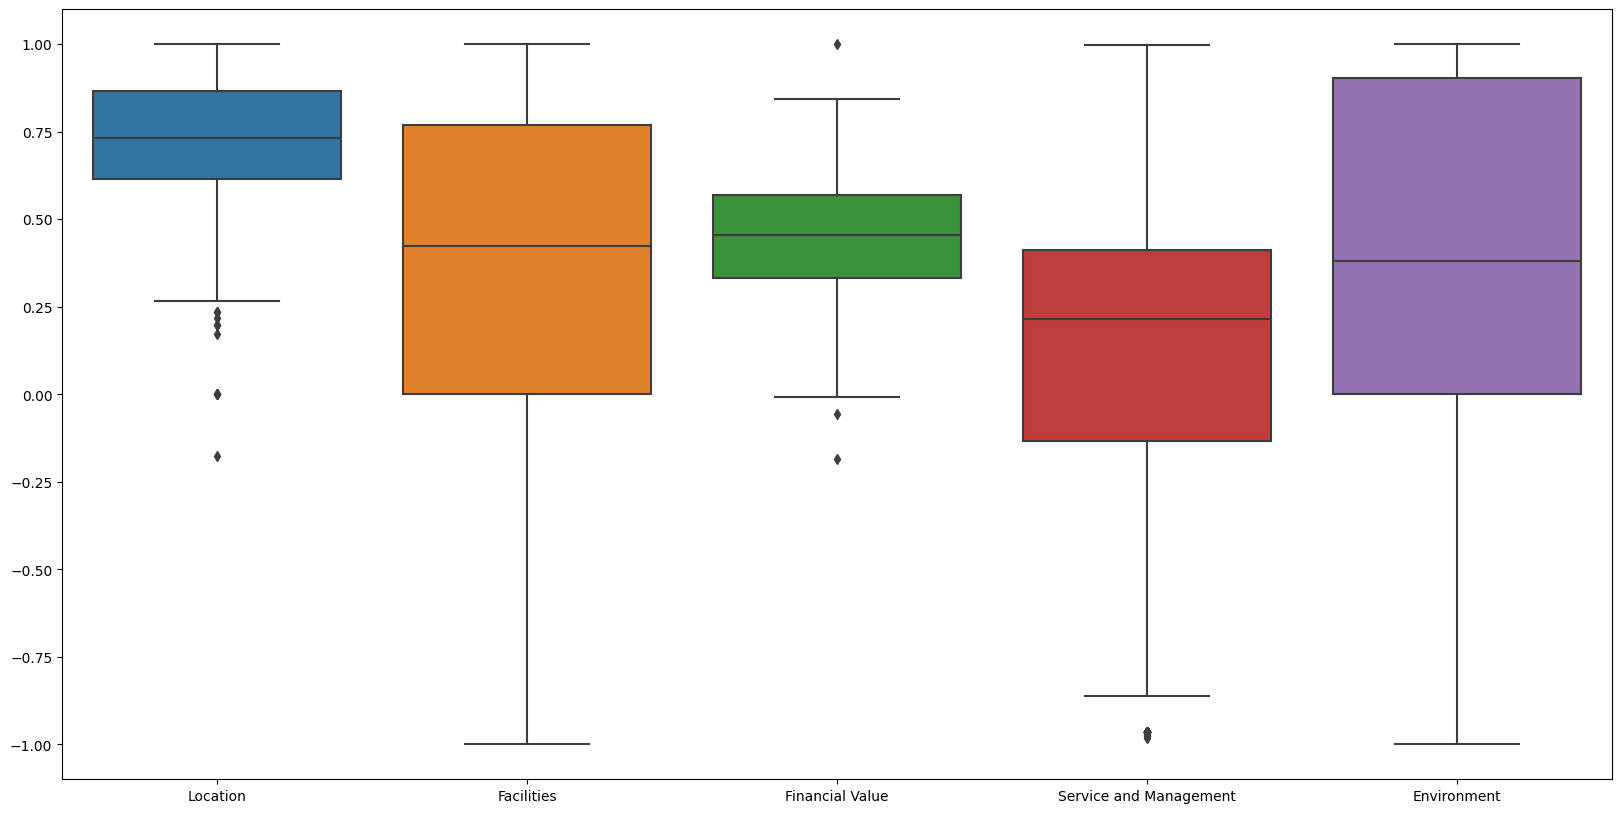

In [10]:
plt.figure(figsize=(20,10))
sns.boxplot(review_final[['Location', 'Facilities', 'Financial Value',
       'Service and Management', 'Environment']])